In [1]:
import torch
import torch.nn as nn
import torchvision.models as models

In [238]:
#Encoder
vgg = models.vgg19(weights='DEFAULT')

vgg = nn.Sequential(*list(vgg.children())[0][:21])

#Decoder
decoder = nn.Sequential(
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 256, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 128, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 64, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 3, (3, 3)),
)

In [36]:
encoder.features[4]

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [37]:
encoder.features[:6]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [239]:
# Functions
def calc_mean_std(feat, eps=1e-5):
    # eps is a small value added to the variance to avoid divide-by-zero.
    size = feat.size()
    assert (len(size) == 4)
    N, C = size[:2]
    feat_var = feat.view(N, C, -1).var(dim=2) + eps
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std

def adaptive_instance_normalization(content_feat, style_feat):
    assert (content_feat.size()[:2] == style_feat.size()[:2])
    size = content_feat.size()
    style_mean, style_std = calc_mean_std(style_feat)
    content_mean, content_std = calc_mean_std(content_feat)

    normalized_feat = (content_feat - content_mean.expand(
        size)) / content_std.expand(size)
    return normalized_feat * style_std.expand(size) + style_mean.expand(size)

def _calc_feat_flatten_mean_std(feat):
    # takes 3D feat (C, H, W), return mean and std of array within channels
    assert (feat.size()[0] == 3)
    assert (isinstance(feat, torch.FloatTensor))
    feat_flatten = feat.view(3, -1)
    mean = feat_flatten.mean(dim=-1, keepdim=True)
    std = feat_flatten.std(dim=-1, keepdim=True)
    return feat_flatten, mean, std


def _mat_sqrt(x):
    U, D, V = torch.svd(x)
    return torch.mm(torch.mm(U, D.pow(0.5).diag()), V.t())

def coral(source, target):
    # assume both source and target are 3D array (C, H, W)
    # Note: flatten -> f

    source_f, source_f_mean, source_f_std = _calc_feat_flatten_mean_std(source)
    source_f_norm = (source_f - source_f_mean.expand_as(
        source_f)) / source_f_std.expand_as(source_f)
    source_f_cov_eye = \
        torch.mm(source_f_norm, source_f_norm.t()) + torch.eye(3)

    target_f, target_f_mean, target_f_std = _calc_feat_flatten_mean_std(target)
    target_f_norm = (target_f - target_f_mean.expand_as(
        target_f)) / target_f_std.expand_as(target_f)
    target_f_cov_eye = \
        torch.mm(target_f_norm, target_f_norm.t()) + torch.eye(3)

    source_f_norm_transfer = torch.mm(
        _mat_sqrt(target_f_cov_eye),
        torch.mm(torch.inverse(_mat_sqrt(source_f_cov_eye)),
                 source_f_norm)
    )

    source_f_transfer = source_f_norm_transfer * \
                        target_f_std.expand_as(source_f_norm) + \
                        target_f_mean.expand_as(source_f_norm)

    return source_f_transfer.view(source.size())

# Sampler Functions
import numpy as np
from torch.utils import data

def InfiniteSampler(n):
    # i = 0
    i = n - 1
    order = np.random.permutation(n)
    while True:
        yield order[i]
        i += 1
        if i >= n:
            np.random.seed()
            order = np.random.permutation(n)
            i = 0

class InfiniteSamplerWrapper(data.sampler.Sampler):
    def __init__(self, data_source):
        self.num_samples = len(data_source)

    def __iter__(self):
        return iter(InfiniteSampler(self.num_samples))

    def __len__(self):
        return 2 ** 31

In [235]:
#nn.Sequential(*list(vgg.children())[:1])
list(vgg.children())[:6]

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]

In [242]:
#Adain Network
class Net(nn.Module):
    def __init__(self, encoder, decoder):
        super(Net, self).__init__()
        enc_layers = list(encoder.children()) # relus setup for default vgg19 (if this causes issues, change setup to custom vgg)
        self.enc_1 = nn.Sequential(*enc_layers[:2])  # input -> relu1_1
        self.enc_2 = nn.Sequential(*enc_layers[2:7])  # relu1_1 -> relu2_1
        self.enc_3 = nn.Sequential(*enc_layers[7:12])  # relu2_1 -> relu3_1
        self.enc_4 = nn.Sequential(*enc_layers[12:21])  # relu3_1 -> relu4_1

        self.decoder = decoder
        self.mse_loss = nn.MSELoss()

        # fix the encoder
        for name in ['enc_1', 'enc_2', 'enc_3', 'enc_4']:
            for param in getattr(self, name).parameters():
                param.requires_grad = False

    # extract relu1_1, relu2_1, relu3_1, relu4_1 from input image
    def encode_with_intermediate(self, input):
        results = [input]
        for i in range(4):
            func = getattr(self, 'enc_{:d}'.format(i + 1))
            results.append(func(results[-1]))
        return results[1:]

    # extract relu4_1 from input image
    def encode(self, input):
        for i in range(4):
            input = getattr(self, 'enc_{:d}'.format(i + 1))(input)
        return input

    def calc_content_loss(self, input, target):
        assert (input.size() == target.size())
        assert (target.requires_grad is False)
        return self.mse_loss(input, target)

    def calc_style_loss(self, input, target):
        assert (input.size() == target.size())
        assert (target.requires_grad is False)
        input_mean, input_std = calc_mean_std(input)
        target_mean, target_std = calc_mean_std(target)
        return self.mse_loss(input_mean, target_mean) + \
               self.mse_loss(input_std, target_std)

    def forward(self, content, style, alpha=1.0):
        assert 0 <= alpha <= 1
        style_feats = self.encode_with_intermediate(style)
        content_feat = self.encode(content)
        t = adaptive_instance_normalization(content_feat, style_feats[-1])
        t = alpha * t + (1 - alpha) * content_feat

        g_t = self.decoder(t)
        g_t_feats = self.encode_with_intermediate(g_t)

        loss_c = self.calc_content_loss(g_t_feats[-1], t)
        loss_s = self.calc_style_loss(g_t_feats[0], style_feats[0])
        for i in range(1, 4):
            loss_s += self.calc_style_loss(g_t_feats[i], style_feats[i])
        return loss_c, loss_s

In [145]:
!pip install tensorboardX
!pip install livelossplot

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


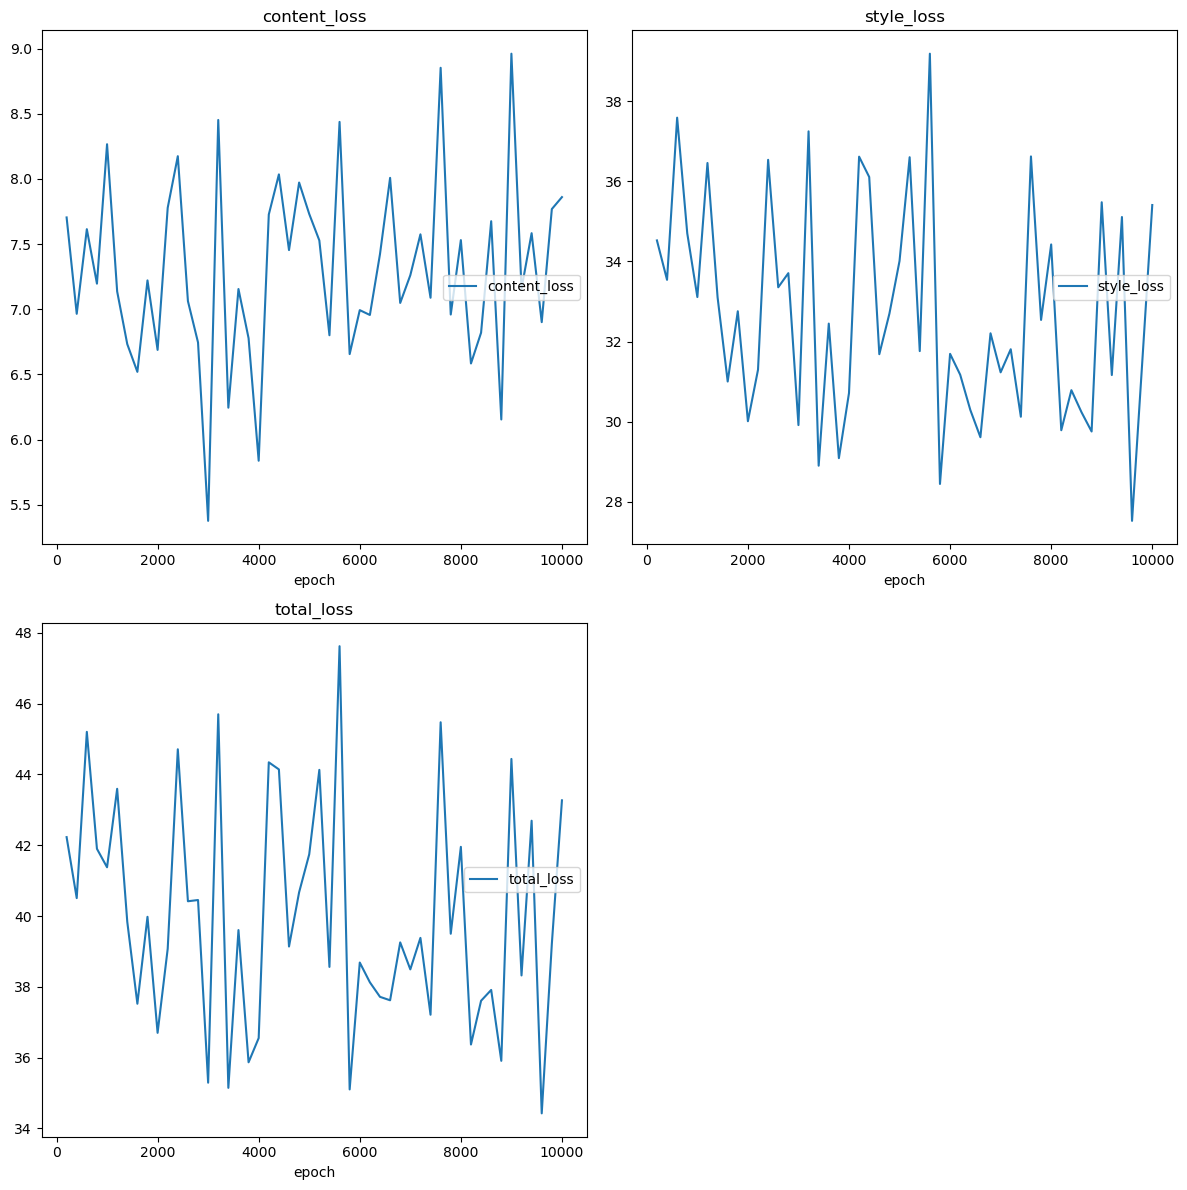

100%|██████████| 10000/10000 [32:46<00:00,  5.09it/s]

content_loss
	content_loss     	 (min:    5.377, max:    8.960, cur:    7.860)
style_loss
	style_loss       	 (min:   27.525, max:   39.186, cur:   35.409)
total_loss
	total_loss       	 (min:   34.426, max:   47.623, cur:   43.269)
tensor(7.8602, device='cuda:0', grad_fn=<MulBackward0>) tensor(35.4089, device='cuda:0', grad_fn=<MulBackward0>) tensor(43.2691, device='cuda:0', grad_fn=<AddBackward0>)


In [287]:
#Training Modified
from pathlib import Path
import livelossplot

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.utils.data as data
from PIL import Image, ImageFile
from tensorboardX import SummaryWriter
from torchvision import transforms
from tqdm import tqdm

cudnn.benchmark = True
Image.MAX_IMAGE_PIXELS = None  # Disable DecompressionBombError
# Disable OSError: image file is truncated
ImageFile.LOAD_TRUNCATED_IMAGES = True


def train_transform():
    transform_list = [
        transforms.Resize(size=(512, 512)),
        transforms.RandomCrop(256),
        transforms.ToTensor()
    ]
    return transforms.Compose(transform_list)


class FlatFolderDataset(data.Dataset): # Looks good
    def __init__(self, root, transform):
        super(FlatFolderDataset, self).__init__()
        self.root = root
        self.paths = list(Path(self.root).glob('*'))
        self.transform = transform

    def __getitem__(self, index):
        path = self.paths[index]
        if path == Path(f"{self.root}/.DS_Store"):
            path = self.paths[index-1]
        img = Image.open(str(path)).convert('RGB')
        img = self.transform(img)
        return img

    def __len__(self):
        return len(self.paths)

    def name(self):
        return 'FlatFolderDataset'

my_lr = 2e-4
my_lr_decay = 1e-4

def adjust_learning_rate(optimizer, iteration_count): # Looks good
    """Imitating the original implementation"""
    lr = my_lr / (1.0 + my_lr_decay * iteration_count)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_dir = Path('./experiments')
save_dir.mkdir(exist_ok=True, parents=True)
log_dir = Path('./logs') # CHANGE ARGS
log_dir.mkdir(exist_ok=True, parents=True)
#writer = SummaryWriter(log_dir=str(log_dir)) # Optional

#decoder = net.decoder # CHANGE unnecessary since it's written in code box above
decoder.load_state_dict(torch.load("./saves/decoder_iter_5000_6.pth.tar", weights_only=True))
#vgg.load_state_dict(torch.load(args.vgg)) # CHANGE unnecessary since using pretrained vgg19

network = Net(vgg, decoder)
network.train()
network.to(device)

content_dataset = FlatFolderDataset('content_images', train_transform()) 
style_dataset = FlatFolderDataset('style_images', train_transform()) 

content_iter = iter(data.DataLoader( # Looks good
    content_dataset, batch_size=16,
    sampler=InfiniteSamplerWrapper(content_dataset),
    num_workers=8))
style_iter = iter(data.DataLoader( # Looks good
    style_dataset, batch_size=16,
    sampler=InfiniteSamplerWrapper(style_dataset),
    num_workers=8))

optimizer = torch.optim.Adam(network.decoder.parameters(), lr=my_lr)
liveloss = livelossplot.PlotLosses()

for i in tqdm(range(10000)):
    adjust_learning_rate(optimizer, iteration_count=i)
    content_images = next(content_iter).to(device)
    style_images = next(style_iter).to(device)
    loss_c, loss_s = network(content_images, style_images)
    loss_c = 1.0 * loss_c
    loss_s = 20.0 * loss_s
    loss = loss_c + loss_s

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #writer.add_scalar('loss_content', loss_c.item(), i + 1)
    #writer.add_scalar('loss_style', loss_s.item(), i + 1)

    if (i + 1) % 200 == 0:
        liveloss.update({"style_loss": loss_s.detach().cpu().numpy(), 
                         "content_loss": loss_c.detach().cpu().numpy(), 
                         "total_loss": loss.detach().cpu().numpy()},
                        current_step=i+1)
        liveloss.send()

    if (i + 1) % 1000 == 0 or (i + 1) == 10000:
        print(loss_c, loss_s, loss)
        state_dict = decoder.state_dict()
        for key in state_dict.keys():
            state_dict[key] = state_dict[key].to(torch.device('cpu'))
        torch.save(state_dict, save_dir /
                   'decoder_iter_{:d}.pth.tar'.format(i + 1))
#writer.close()

In [296]:
#TESTING

from pathlib import Path

import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np


def test_transform(size, crop):
    transform_list = []
    if size != 0:
        transform_list.append(transforms.Resize(size))
    if crop:
        transform_list.append(transforms.CenterCrop(size))
    transform_list.append(transforms.ToTensor())
    transform = transforms.Compose(transform_list)
    return transform


def style_transfer(vgg, decoder, content, style, alpha=1.0,
                   interpolation_weights=None):
    assert (0.0 <= alpha <= 1.0)
    content_f = vgg(content)
    style_f = vgg(style)
    #plt.imshow(content_f[0][25].detach().cpu().numpy())
    if interpolation_weights:
        _, C, H, W = content_f.size()
        feat = torch.FloatTensor(1, C, H, W).zero_().to(device)
        base_feat = adaptive_instance_normalization(content_f, style_f)
        for i, w in enumerate(interpolation_weights):
            feat = feat + w * base_feat[i:i + 1]
        content_f = content_f[0:1]
    else:
        feat = adaptive_instance_normalization(content_f, style_f)
    feat = feat * alpha + content_f * (1 - alpha)
    return decoder(feat)

# Basic options
my_content = "./content_images/000000000370.jpg"
my_content_dir = "./content_images"
my_style = "./style_images/Lore Olympus_ep8_0.jpg"
#my_style = "./style_images/Answer Me, My Prince_ep2_2.jpg"
#my_style = "./style_images/Mystical_ep5_2.jpg"
#my_style = "style.jpg"
my_style_dir = "./content_images"
my_decoder = "./experiments/decoder_iter_3000.pth.tar"
my_vgg = ""

# Additional options
my_content_size = 512
my_style_size = 512
my_crop = False
my_save_ext = ".jpg"
my_output = "output"
my_preserve_color = False
my_alpha = 1.0
my_style_interpolation_weights = ""

do_interpolation = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

output_dir = Path(my_output) 
output_dir.mkdir(exist_ok=True, parents=True)

# Either --content or --contentDir should be given.
assert (my_content or my_content_dir)
if my_content:
    content_paths = [Path(my_content)]
else:
    content_dir = Path(my_content_dir)
    content_paths = [f for f in content_dir.glob('*')]

# Either --style or --styleDir should be given.
assert (my_style or my_style_dir)
if my_style:
    style_paths = [my_style]
    if len(style_paths) == 1:
        style_paths = [Path(my_style)]
    else:
        do_interpolation = True
        assert (my_style_interpolation_weights != ''), \
            'Please specify interpolation weights'
        weights = [int(i) for i in my_style_interpolation_weights.split(',')]
        interpolation_weights = [w / sum(weights) for w in weights]
else:
    style_dir = Path(my_style_dir)
    style_paths = [f for f in style_dir.glob('*')]

decoder.eval()
vgg.eval()

decoder.load_state_dict(torch.load(my_decoder, weights_only=True))
#vgg.load_state_dict(torch.load(my_vgg))

vgg.to(device)
decoder.to(device)

content_tf = test_transform(my_content_size, my_crop)
style_tf = test_transform(my_style_size, my_crop)

for content_path in content_paths:
    if do_interpolation:  # one content image, N style image
        style = torch.stack([style_tf(Image.open(str(p))) for p in style_paths])
        content = content_tf(Image.open(str(content_path))) \
            .unsqueeze(0).expand_as(style)
        style = style.to(device)
        content = content.to(device)
        with torch.no_grad():
            output = style_transfer(vgg, decoder, content, style,
                                    my_alpha, interpolation_weights)
        output = output.cpu()
        output_name = output_dir / '{:s}_interpolation{:s}'.format(
            content_path.stem, my_save_ext)
        save_image(output, str(output_name))

    else:  # process one content and one style
        for style_path in style_paths:
            content = content_tf(Image.open(str(content_path)))
            style = style_tf(Image.open(str(style_path)))
            if my_preserve_color:
                style = coral(style, content)
            style = style.to(device).unsqueeze(0)
            content = content.to(device).unsqueeze(0)
            with torch.no_grad():
                output = style_transfer(vgg, decoder, content, style,
                                        my_alpha)
            output = output.cpu()

            output_name = output_dir / '{:s}_stylized_{:s}{:s}'.format(
                content_path.stem, style_path.stem, my_save_ext)
            save_image(output, str(output_name))
            